# London Exploratory Data Analysis

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import geopandas as gpd
from matplotlib.path import Path

import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM

In [24]:
# Read in data into memory
csvs = [x for x in os.listdir() if ".csv" in x]

d = {}
for file in csvs:
    file_str = file.replace(".csv","").replace("-","_")
    try:
        d[file_str] = pd.read_csv(file)
    except:
        print("{0} requires unicode_escaping".format(file))
        d[file_str] = pd.read_csv(file, encoding='unicode_escape')

## UK Datasets 

### Inflation

In [43]:
# We tackle UK datasets first
UK_inflation = d['UK_inflation']
UK_inflation.set_index("year", inplace=True)
UK_inflation["inverse_multiplier"] = UK_inflation['multiplier'].apply(lambda x: 1/x)
UK_inflation.head()

,inflation,multiplier,inverse_multiplier
year,,,
2018,NaN,1.00,1.000000
2017,0.036,1.04,0.961538
2016,0.018,1.05,0.952381
2015,0.010,1.07,0.934579
2014,0.024,1.09,0.917431


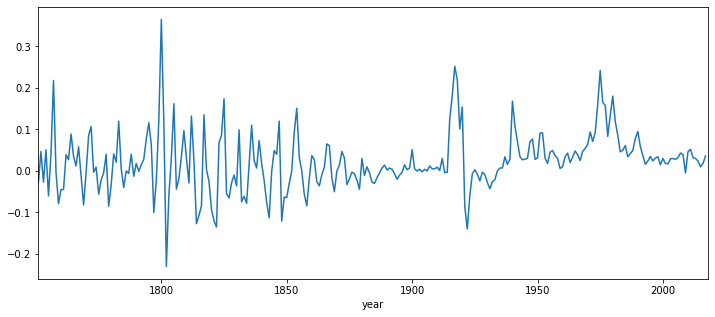

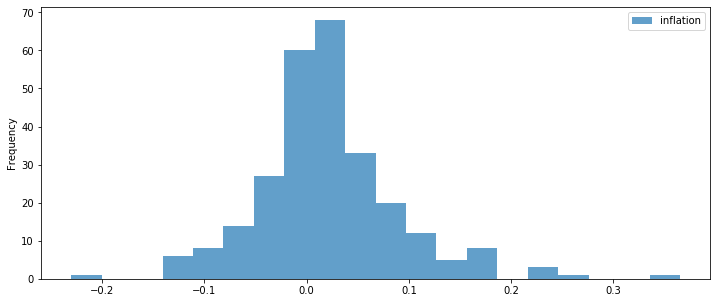

In [54]:
# Annual inflation rate (presumably)
## Looks like we can pretty much discard the time series prior to 1950
UK_inflation['inflation'].plot(figsize=(12,5))
UK_inflation.reset_index()[['inflation']].plot.hist(figsize=(12,5), bins=20, alpha=0.7)

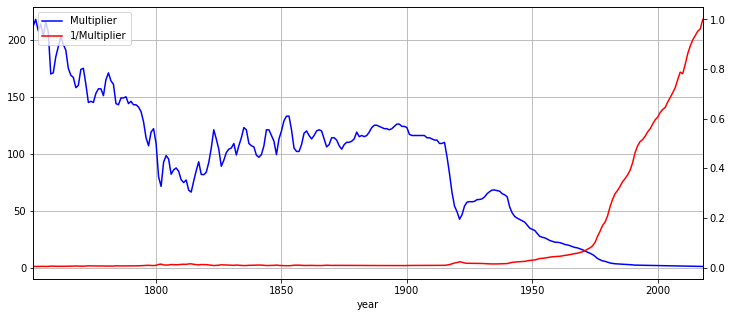

In [45]:
## Will need to figure out how to interpret inflation and multiplier
plt.figure(figsize=(12,5))
plt.xlabel('Year')

ax1 = UK_inflation.multiplier.plot(color='blue', grid=True, label='Multiplier')
ax2 = UK_inflation.inverse_multiplier.plot(color='red', grid=True, secondary_y=True, label='1/Multiplier')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()


plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

### UK International visits

In [70]:
UK_international_visits = d["UK_international_visits"]
UK_international_visits.tail()

,year,quarter,market,dur_stay,mode,purpose,area,visits,spend,nights,sample
549848,2019P,July-September,Other Africa,15+ nights,Air,Study,ALL STAYING VISITS,0.464177,0.835519,41.775928,1
549849,2019P,July-September,Other Africa,15+ nights,Air,Miscellaneous,TOTAL ENGLAND,1.071057,1.122145,21.994084,2
549850,2019P,July-September,Other Africa,15+ nights,Air,Miscellaneous,LONDON,1.071057,1.122145,21.994084,2
549851,2019P,July-September,Other Africa,15+ nights,Air,Miscellaneous,WALES,0.572944,0.176619,5.729440,1
549852,2019P,July-September,Other Africa,15+ nights,Air,Miscellaneous,ALL STAYING VISITS,1.071057,1.298764,27.723525,2


In [75]:
## Distinct markets
distinct_markets = UK_international_visits["market"].unique()
non_countries = [x for x in distinct_markets if x.split(' ')[0]=="Other"]
countries = set(distinct_markets).difference(set(non_countries))

In [65]:
UK_international_visits_countries = UK_international_visits[UK_international_visits["market"].isin(countries)]

In [72]:
print("Total size: {0}".format(UK_international_visits.shape))
print("Filtered size: {0}".format(UK_international_visits_countries.shape))

Total size: (549853, 11)
Filtered size: (498368, 11)


In [77]:
distinct_areas = UK_international_visits["area"].unique()
distinct_areas

array(['TOTAL ENGLAND', 'LONDON', 'REST OF ENGLAND', 'SOUTHERN ENGLAND',
       'SOUTH EAST', 'SCOTLAND', 'ALL STAYING VISITS',
       "ENGLAND'S NORTH COUNTRY", 'CENTRAL ENGLAND', 'NORTH EAST',
       'NORTH WEST', 'WEST MIDLANDS', 'EAST MIDLANDS', 'EAST OF ENGLAND',
       'SOUTH WEST', 'YORKSHIRE', 'WALES', ' NORTHERN IRELAND',
       ' OIL RIGS/TRAVELLING', ' ISLE OF MAN', ' CHANNEL ISLANDS'],
      dtype=object)

In [91]:
## Can we get a world heatmap with weights corresponding to visits/spend/nights?

shapefile = "Longitude_Graticules_and_World_Countries_Boundaries-shp/99bfd9e7-bb42-4728-87b5-07f8c8ac631c2020328-1-1vef4ev.lu5nk.shp"
#Read shapefile using Geopandas
gdf = gpd.read_file(shapefile)[["CNTRY_NAME", "geometry"]]
gdf.rename(columns={"CNTRY_NAME":"country"},inplace=True)

In [113]:
UK_visits_2012_Q1 = UK_international_visits[(UK_international_visits["year"] == 2012) & (UK_international_visits["quarter"] == 'January-March')]
UK_visits_2012_Q1 = UK_visits_2012_Q1[["market", "visits", "spend", "nights"]]

UK_visits_2012_Q1_agg = UK_visits_2012_Q1.groupby("market").agg(sum)
UK_visits_2012_Q1_agg.reset_index(inplace=True)

In [114]:
# UK_visits_2012_Q1_agg = UK_visits_2012_Q1_agg.merge(gdf, left_on="market", right_on="country")
UK_visits_2012_Q1_agg_geo = gdf.merge(UK_visits_2012_Q1_agg, left_on="country", right_on="market")

In [124]:
UK_visits_2012_Q1_agg_geo["visits"] = UK_visits_2012_Q1_agg_geo["visits"].fillna(0)
UK_visits_2012_Q1_agg_geo["spend"] = UK_visits_2012_Q1_agg_geo["spend"].fillna(0)
UK_visits_2012_Q1_agg_geo["nights"] = UK_visits_2012_Q1_agg_geo["nights"].fillna(0)

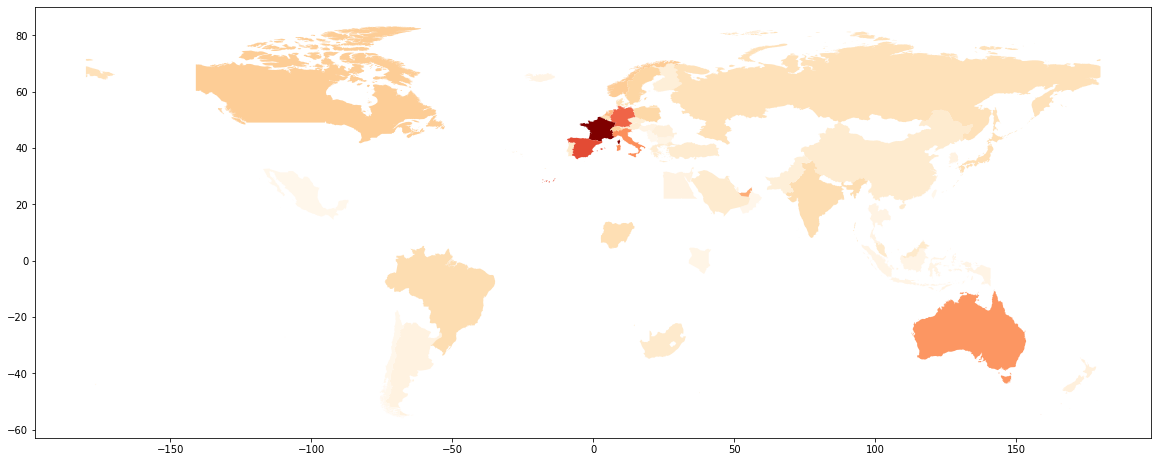

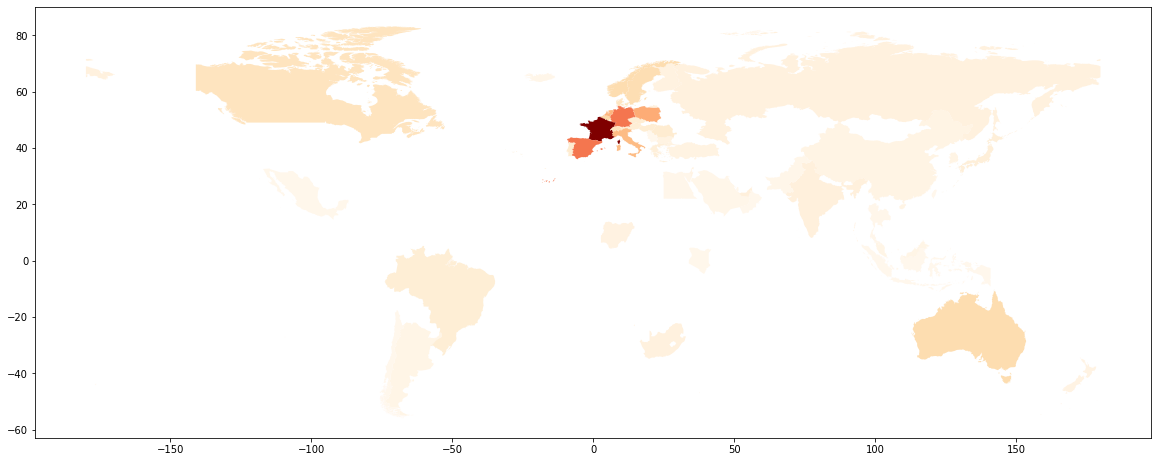

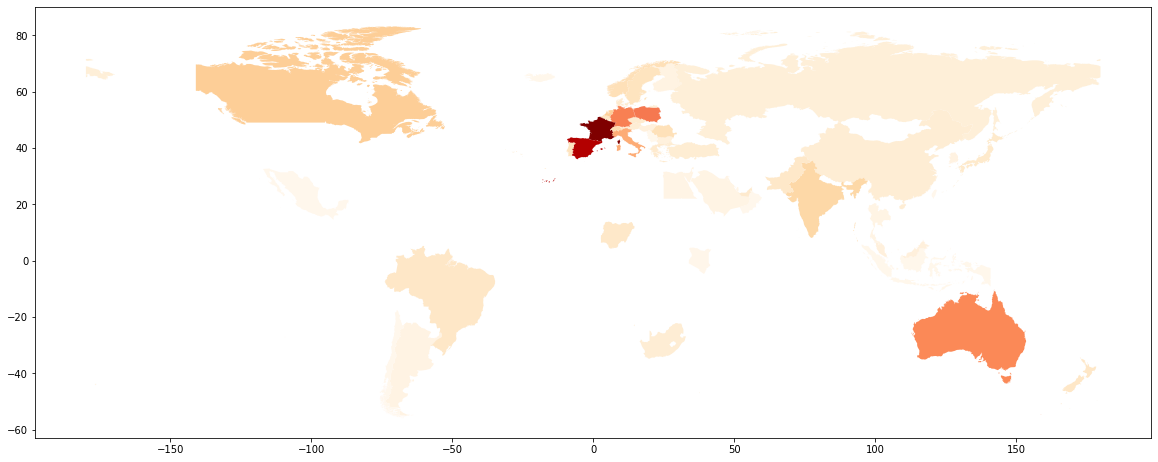

In [127]:
UK_visits_2012_Q1_agg_geo.plot(column="spend", cmap="OrRd", figsize=(20,10))
UK_visits_2012_Q1_agg_geo.plot(column="visits", cmap="OrRd", figsize=(20,10))
UK_visits_2012_Q1_agg_geo.plot(column="nights", cmap="OrRd", figsize=(20,10))

In [128]:
london_underground_activity = d["london_underground_activity"]

In [141]:
london_underground_activity.head()
print(london_underground_activity.shape)

(2953, 11)


In [131]:
print(len(london_underground_activity["station"].unique()))
print(len(london_underground_activity["area"].unique()))

275
32


In [142]:
london_underground_st_info = d["london_underground_station_info"]

In [143]:
london_underground_st_info.head()

,station,line,local_authority,zone,opened
0,Acton Town,District,Ealing,3,1879-07-01
1,Aldgate,Metropolitan[a],City of London,1,1876-11-18
2,Aldgate East,Hammersmith & City[d],Tower Hamlets,1,1884-10-06
3,Alperton,Piccadilly[h],Brent,4,1903-06-28
4,Amersham,Metropolitan,Chiltern,9,1892-09-01


In [144]:
london_earnings_by_borough = d["london_earnings_by_borough"]

In [146]:
london_earnings_by_borough.shape

(6768, 7)

In [147]:
london_economic_activity = d["london_economic_activity"]

In [148]:
london_economic_activity.head()

,year,area_code,area,gender,economically_active,working_age,percent,confidence
0,Jan 2005-Dec 2005,00AA,City of London,F,2400.0,3600.0,64.4,NaN
1,Jan 2006-Dec 2006,00AA,City of London,F,NaN,NaN,NaN,NaN
2,Jan 2007-Dec 2007,00AA,City of London,F,NaN,1400.0,NaN,NaN
3,Jan 2008-Dec 2008,00AA,City of London,F,1200.0,1200.0,100.0,NaN
4,Jan 2009-Dec 2009,00AA,City of London,F,NaN,NaN,NaN,NaN
